In [1]:
# ===============================================================
# BBL — Pre-game Logistic Model (with Elo + venue + AIC selection)
# Features:
#   • is_home, toss_won, team_bats_first, toss_won_bat_first
#   • form_rate, form_diff   (rolling window)
#   • home_toss_won, home_toss_bat_first
#   • is_home_x_toss_won
#   • elo_team, elo_opp, elo_diff
#   • venue_win_rate
#
# Models:
#   1) Full logistic regression with cluster-robust SEs by match_id
#   2) Backward AIC selection → reduced model
#   3) Reduced model with cluster-robust SEs
#   4) Toss / bat-first binomial tests (Section 3.9)
# ===============================================================

import os
import json
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy.stats import norm, binomtest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.sandwich_covariance import cov_cluster

# ----------------------------
# Paths (EDIT THESE)
# ----------------------------
DATA_DIR = r"C:\Users\saisu\Downloads\bbl_json"   # folder of Cricsheet JSON
OUT_DIR  = r"C:\Users\saisu\Downloads"            # where CSVs will be saved

# ----------------------------
# Globals / constants
# ----------------------------
FORM_WINDOW = 8
ELO_INIT    = 1500.0
ELO_K       = 20.0


def parse_date(any_date):
    """Handle Cricsheet 'dates' field (list or scalar) safely."""
    if any_date is None:
        return pd.NaT
    if isinstance(any_date, list) and len(any_date) > 0:
        any_date = any_date[0]
    return pd.to_datetime(any_date, errors="coerce")


def infer_home_team(venue: str, team1: str, team2: str):
    """Infer BBL home team from venue string."""
    v = str(venue or "")
    rules = [
        ("Sydney Cricket Ground", "Sydney Sixers"),
        ("Sydney Showground Stadium", "Sydney Thunder"),
        ("Adelaide Oval", "Adelaide Strikers"),
        ("Perth Stadium", "Perth Scorchers"),
        ("Western Australia Cricket Association Ground", "Perth Scorchers"),
        ("Brisbane Cricket Ground", "Brisbane Heat"),
        ("Woolloongabba", "Brisbane Heat"),
        ("Bellerive Oval", "Hobart Hurricanes"),
        ("Launceston", "Hobart Hurricanes"),
        ("Marvel Stadium", "Melbourne Renegades"),
        ("Docklands Stadium", "Melbourne Renegades"),
        ("Melbourne Cricket Ground", "Melbourne Stars"),
        ("Manuka Oval", None),  # neutral
    ]
    for key, home in rules:
        if key in v and (home is None or home in (team1, team2)):
            return home
    return None


# ----------------------------
# 1) Parse JSON → match-level
# ----------------------------
def parse_all_matches(data_dir: str) -> pd.DataFrame:
    files = [f for f in os.listdir(data_dir) if f.lower().endswith(".json")]
    files.sort()
    print(f"Found {len(files)} JSON files")

    rows = []
    for i, fn in enumerate(files, start=1):
        if i % 25 == 0 or i == len(files):
            print(f"Processing {i}/{len(files)}: {fn}")
        with open(os.path.join(data_dir, fn), "r", encoding="utf-8") as f:
            x = json.load(f)

        info = x.get("info", {}) or {}
        outcome = info.get("outcome", {}) or {}
        toss    = info.get("toss", {}) or {}
        teams   = info.get("teams", [None, None]) or [None, None]

        # Skip invalid or non-decisive results
        result_text = str(outcome.get("result", "")).lower()
        if result_text in {"tie", "no result"}:
            continue

        season = info.get("season")
        team1  = teams[0] if len(teams) > 0 else None
        team2  = teams[1] if len(teams) > 1 else None
        if team1 is None or team2 is None:
            continue

        date  = parse_date(info.get("dates"))
        venue = info.get("venue")
        home_team = infer_home_team(venue, team1, team2)

        toss_winner   = toss.get("winner")
        toss_decision = (str(toss.get("decision") or "").strip().lower())
        winner        = outcome.get("winner")

        # Derive batting-first team from toss
        batting_first = None
        if toss_winner:
            if toss_decision == "bat":
                batting_first = toss_winner
            elif toss_decision in ("field", "bowl"):
                batting_first = team2 if toss_winner == team1 else team1

        # Drop if any key field missing
        if winner is None or toss_winner is None or batting_first is None:
            continue

        rows.append({
            "match_id": fn.replace(".json", ""),
            "date": date,
            "season": season,
            "team1": team1,
            "team2": team2,
            "venue": venue,
            "home_team": home_team,
            "toss_winner": toss_winner,
            "toss_decision": toss_decision,
            "batting_first": batting_first,
            "winner": winner,
        })

    df = pd.DataFrame(rows).sort_values(["date", "match_id"]).reset_index(drop=True)
    print(f"\nTotal parsed matches: {len(df)}")
    return df


# ----------------------------
# 1b) Toss / bat-first binomial tests (Section 3.9)
# ----------------------------
def toss_bat_first_binomial_tests(match_df: pd.DataFrame):
    """
    Section 3.9: simple toss / bat-first proportions and
    two-sided binomial tests against p = 0.5.
    """
    print("\n=== Toss / Bat-first analysis (Section 3.9) ===")

    # a) Toss winner wins the match?
    a_total = len(match_df)
    a_wins = (match_df["toss_winner"] == match_df["winner"]).sum()
    a_prop = a_wins / a_total
    a_test = binomtest(a_wins, a_total, p=0.5, alternative="two-sided")
    print(
        f"a) Toss winner wins match: {a_prop:.3f} "
        f"({a_wins}/{a_total}), p-value={a_test.pvalue:.4f}"
    )

    # b) Batting first wins the match?
    b_total = len(match_df)
    b_wins = (match_df["batting_first"] == match_df["winner"]).sum()
    b_prop = b_wins / b_total
    b_test = binomtest(b_wins, b_total, p=0.5, alternative="two-sided")
    print(
        f"b) Team batting first wins: {b_prop:.3f} "
        f"({b_wins}/{b_total}), p-value={b_test.pvalue:.4f}"
    )

    # c) Among toss-winners who chose to bat, proportion that won
    c_df = match_df[match_df["toss_decision"] == "bat"]
    c_total = len(c_df)
    if c_total > 0:
        c_wins = (c_df["toss_winner"] == c_df["winner"]).sum()
        c_prop = c_wins / c_total
        c_test = binomtest(c_wins, c_total, p=0.5, alternative="two-sided")
        print(
            f"c) Toss winner chose bat & won: {c_prop:.3f} "
            f"({c_wins}/{c_total}), p-value={c_test.pvalue:.4f}"
        )
    else:
        print("c) No matches where toss winner chose to bat found.")


# ----------------------------
# 2) Build team-by-match features
# ----------------------------
def build_team_features(match_df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a long-format table: 2 rows per match (one per team) with:
      - home/toss/batting indicators
      - rolling form (form_rate, form_diff)
      - Elo ratings (elo_team, elo_opp, elo_diff)
      - venue_win_rate (historical at that ground)
    """
    match_df = match_df.sort_values(["date", "match_id"]).reset_index(drop=True)

    form_hist: Dict[str, List[int]] = {}           # team -> list of past win_flags
    elo: Dict[str, float] = {}                     # team -> current Elo rating
    venue_stats: Dict[str, Dict[str, int]] = {}    # venue -> {games, wins}

    rows = []

    for _, r in match_df.iterrows():
        match_id = r["match_id"]
        season   = r["season"]
        date     = r["date"]
        venue    = r["venue"]
        t1       = r["team1"]
        t2       = r["team2"]
        home     = r["home_team"]
        tw       = r["toss_winner"]
        bf       = r["batting_first"]
        winner   = r["winner"]

        # Venue history BEFORE this match
        vstats = venue_stats.get(venue, {"games": 0, "wins": 0})
        if vstats["games"] > 0:
            vwr = vstats["wins"] / vstats["games"]
        else:
            vwr = 0.5  # neutral for first match at venue

        # Current Elo BEFORE this match
        elo_t1 = elo.get(t1, ELO_INIT)
        elo_t2 = elo.get(t2, ELO_INIT)

        # Current form BEFORE this match
        hist1 = form_hist.get(t1, [])
        hist2 = form_hist.get(t2, [])

        f1 = np.mean(hist1[-FORM_WINDOW:]) if hist1 else 0.5
        f2 = np.mean(hist2[-FORM_WINDOW:]) if hist2 else 0.5

        # helper to create one row per team
        def make_row(team, opp, team_elo, opp_elo, self_form, opp_form, won_flag):
            is_home = int(home == team) if pd.notna(home) else 0
            toss_won = int(tw == team)
            team_bats_first = int(bf == team)
            toss_won_bat_first = int(toss_won and team_bats_first)
            home_toss_won = int(home is not None and tw == home)
            home_toss_bat_first = int(home_toss_won and bf == home)
            is_home_x_toss_won = is_home * toss_won
            return {
                "match_id": match_id,
                "season": season,
                "date": date,
                "venue": venue,
                "team": team,
                "opp": opp,
                "is_home": is_home,
                "toss_won": toss_won,
                "team_bats_first": team_bats_first,
                "toss_won_bat_first": toss_won_bat_first,
                "form_rate": self_form,
                "form_diff": self_form - opp_form,
                "home_toss_won": home_toss_won,
                "home_toss_bat_first": home_toss_bat_first,
                "elo_team": team_elo,
                "elo_opp": opp_elo,
                "venue_win_rate": vwr,
                "win_flag": int(winner == team),
                "is_home_x_toss_won": is_home_x_toss_won,
                "elo_diff": team_elo - opp_elo,
            }

        # Row for team1
        rows.append(make_row(t1, t2, elo_t1, elo_t2, f1, f2, int(winner == t1)))
        # Row for team2
        rows.append(make_row(t2, t1, elo_t2, elo_t1, f2, f1, int(winner == t2)))

        # ---- Update histories AFTER match ----
        # Update form
        form_hist.setdefault(t1, []).append(int(winner == t1))
        form_hist.setdefault(t2, []).append(int(winner == t2))

        # Update Elo
        RA = elo_t1
        RB = elo_t2
        EA = 1.0 / (1.0 + 10.0 ** ((RB - RA) / 400.0))
        SA = 1.0 if winner == t1 else 0.0
        SB = 1.0 - SA
        RA_new = RA + ELO_K * (SA - EA)
        RB_new = RB + ELO_K * (SB - (1.0 - EA))
        elo[t1] = RA_new
        elo[t2] = RB_new

        # Update venue history
        vstats["games"] += 1
        if winner in (t1, t2):
            vstats["wins"] += 1
        venue_stats[venue] = vstats

    feat = pd.DataFrame(rows)

    out_path = os.path.join(OUT_DIR, "bbl_team_features.csv")
    feat.to_csv(out_path, index=False)
    print(f"\nSaved team features → {out_path}")
    print(feat.head(10).to_string(index=False))

    return feat


# ----------------------------
# 3) Predictor diagnostics
# ----------------------------
def print_predictor_diagnostics(feat: pd.DataFrame):
    print("\n=== Predictor diagnostics (means & correlation with win_flag) ===")
    cols = [
        "is_home",
        "toss_won",
        "team_bats_first",
        "toss_won_bat_first",
        "form_rate",
        "form_diff",
        "home_toss_won",
        "home_toss_bat_first",
        "is_home_x_toss_won",
        "elo_diff",
        "elo_team",
        "elo_opp",
        "venue_win_rate",
    ]
    for c in cols:
        if c not in feat.columns:
            continue
        m = feat[c].mean()
        corr = feat[c].corr(feat["win_flag"])
        print(f"{c:17s} mean={m:7.3f}   corr(win_flag)={corr:7.3f}")


# ----------------------------
# 4) Logistic regression helpers
# ----------------------------
def fit_logit_cluster(df: pd.DataFrame, predictors: List[str], label: str):
    """
    Fit a logistic regression with cluster-robust SEs on match_id.
    Returns (results, aic).
    """
    dfm = df.dropna(subset=["win_flag"] + predictors).copy()
    X = sm.add_constant(dfm[predictors].astype(float), prepend=True)
    y = dfm["win_flag"].astype(int)
    groups = dfm["match_id"]

    print(f"\n=== Logistic Regression (Cluster-robust by match_id) — {label} ===")
    model = sm.Logit(y, X)
    try:
        res = model.fit(disp=False, cov_type="cluster", cov_kwds={"groups": groups})
        print(res.summary())
    except Exception as e:
        print(f"(Cluster covariance failed, falling back to manual) → {e}")
        res = model.fit(disp=False)
        C = cov_cluster(res, groups)
        res.cov_params_default = C

    # For consistency, compute AIC manually from loglike
    aic = 2 * (len(res.params)) - 2 * res.llf
    return res, aic


def print_interpretation(res, out_csv: str):
    coef = res.params
    se   = res.bse
    z    = coef / se
    pval = 2 * (1 - norm.cdf(np.abs(z)))

    # q-values (FDR)
    _, qvals, _, _ = multipletests(pval, method="fdr_bh")

    orat  = np.exp(coef)
    ci_lo = np.exp(coef - 1.96 * se)
    ci_hi = np.exp(coef + 1.96 * se)

    out = pd.DataFrame({
        "Predictor": coef.index,
        "Coefficient": coef.values,
        "StdErr(cluster)": se.values,
        "z_value": z.values,
        "p_value": pval,
        "q_value(FDR)": qvals,
        "OddsRatio": orat.values,
        "OR_CI_low(95%)": ci_lo.values,
        "OR_CI_high(95%)": ci_hi.values,
    })

    out_path = os.path.join(OUT_DIR, out_csv)
    out.to_csv(out_path, index=False)
    print(f"\nSaved model results → {out_path}")

    print("\nInterpretation:")
    for _, r in out.iterrows():
        name = r["Predictor"]
        print(
            f"  {name}: coef={r['Coefficient']:.3f}, "
            f"OR={r['OddsRatio']:.3f}, "
            f"p={r['p_value']:.4f}, q={r['q_value(FDR)']:.4f}"
        )


# ----------------------------
# 5) Backward AIC selection
# ----------------------------
def backward_aic(feat: pd.DataFrame, base_predictors: List[str]):
    """
    Backward stepwise AIC search starting from base_predictors.
    Returns list of selected predictors and prints the path.
    """
    current_predictors = base_predictors.copy()
    path = []

    # Fit full model
    res_full, aic_full = fit_logit_cluster(feat, current_predictors, "pregame_full_cluster")
    print_interpretation(res_full, "bbl_logit_pregame_full_cluster_cluster.csv")
    current_aic = aic_full

    improved = True
    while improved and len(current_predictors) > 1:
        improved = False
        best_aic = current_aic
        best_drop = None

        for p in current_predictors:
            trial = [q for q in current_predictors if q != p]
            _, trial_aic = fit_logit_cluster(feat, trial, f"drop_{p}")
            print(f"Dropping {p:<20s} → AIC {current_aic:.2f} → {trial_aic:.2f}")
            if trial_aic + 1e-6 < best_aic:
                best_aic = trial_aic
                best_drop = p

        path.append((current_predictors.copy(), current_aic))

        if best_drop is not None:
            current_predictors.remove(best_drop)
            current_aic = best_aic
            improved = True

    # Final path print
    print("\n=== BACKWARD AIC PATH ===")
    for preds, aic in path:
        print(f"Predictors: {preds} → AIC={aic:.2f}")

    print(f"\nChosen AIC model predictors: {current_predictors} (AIC={current_aic:.2f})")
    return current_predictors


# ----------------------------
# 6) Main
# ----------------------------
def main():
    # 1) Parse JSON → match-level
    match_df = parse_all_matches(DATA_DIR)

    # 1b) Toss / bat-first binomial tests for Section 3.9
    toss_bat_first_binomial_tests(match_df)

    # 2) Build team-by-match features
    feat = build_team_features(match_df)

    # 3) Diagnostics
    print_predictor_diagnostics(feat)

    # 4) Backward AIC from full predictor set
    full_predictors = [
        "is_home",
        "toss_won",
        "team_bats_first",
        "toss_won_bat_first",
        "form_rate",
        "form_diff",
        "home_toss_won",
        "home_toss_bat_first",
        "is_home_x_toss_won",
        "elo_diff",
        "venue_win_rate",
    ]

    selected_predictors = backward_aic(feat, full_predictors)

    # 5) Fit final reduced model with cluster SEs
    res_reduced, _ = fit_logit_cluster(feat, selected_predictors, "pregame_reduced_cluster")
    print_interpretation(res_reduced, "bbl_logit_pregame_reduced_cluster_cluster.csv")


if __name__ == "__main__":
    main()


Found 618 JSON files
Processing 25/618: 1023629.json
Processing 50/618: 1114870.json
Processing 75/618: 1114895.json
Processing 100/618: 1152532.json
Processing 125/618: 1152557.json
Processing 150/618: 1195585.json
Processing 175/618: 1195610.json
Processing 200/618: 1226827.json
Processing 225/618: 1226852.json
Processing 250/618: 1226877.json
Processing 275/618: 1269653.json
Processing 300/618: 1269679.json
Processing 325/618: 1324629.json
Processing 350/618: 1324654.json
Processing 375/618: 1324679.json
Processing 400/618: 1386114.json
Processing 425/618: 1443060.json
Processing 450/618: 1443087.json
Processing 475/618: 524926.json
Processing 500/618: 571241.json
Processing 525/618: 654043.json
Processing 550/618: 654095.json
Processing 575/618: 756781.json
Processing 600/618: 897725.json
Processing 618/618: 897763.json

Total parsed matches: 604

=== Toss / Bat-first analysis (Section 3.9) ===
a) Toss winner wins match: 0.523 (316/604), p-value=0.2719
b) Team batting first wins: 0

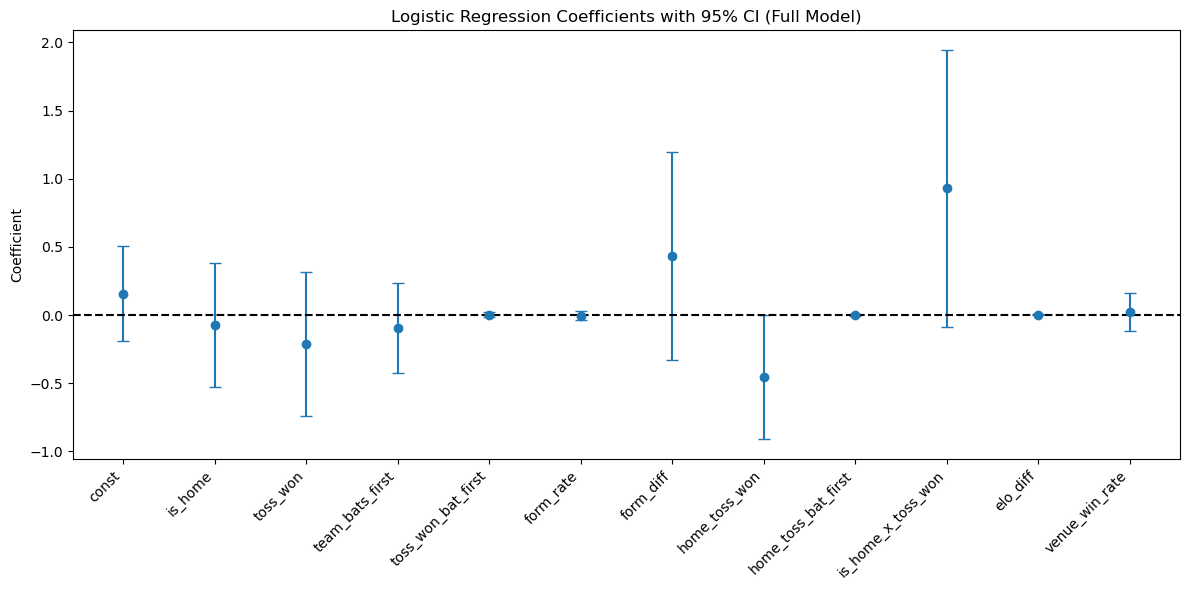

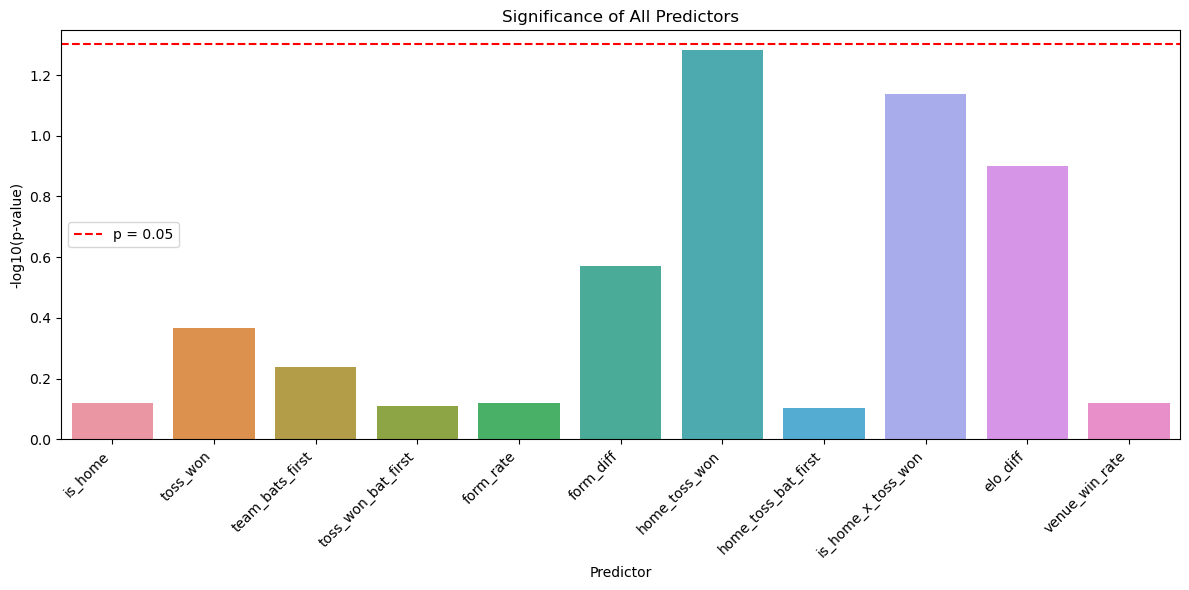

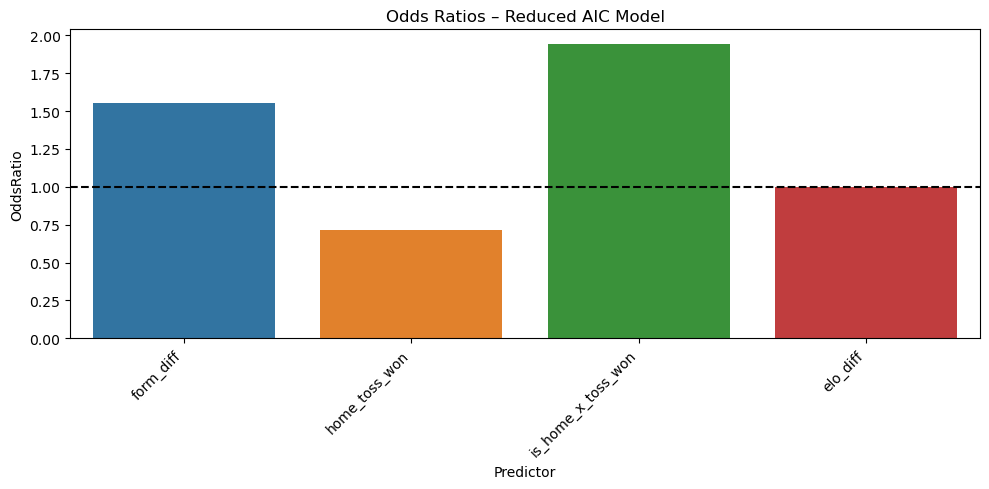

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load your saved CSV results
full = pd.read_csv(r"C:\Users\saisu\Downloads\bbl_logit_pregame_full_cluster_cluster.csv")
reduced = pd.read_csv(r"C:\Users\saisu\Downloads\bbl_logit_pregame_reduced_cluster_cluster.csv")

# ----------------------------------------------------------
# PLOT 1 — COEFFICIENTS with 95% CI (FULL vs REDUCED MODEL)
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.errorbar(
    full["Predictor"],
    full["Coefficient"],
    yerr=1.96*full["StdErr(cluster)"],
    fmt='o',
    label="Full Model",
    capsize=4
)

plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Coefficient")
plt.title("Logistic Regression Coefficients with 95% CI (Full Model)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# PLOT 2 — ALL p-values (–log10 p)
# ----------------------------------------------------------
full_no_const = full[full["Predictor"] != "const"].copy()
full_no_const["neglog10p"] = -np.log10(full_no_const["p_value"])

plt.figure(figsize=(12,6))
sns.barplot(
    data=full_no_const,
    x="Predictor",
    y="neglog10p"
)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xticks(rotation=45, ha='right')
plt.ylabel("-log10(p-value)")
plt.title("Significance of All Predictors")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# PLOT 3 — Odds Ratios for Reduced Model
# ----------------------------------------------------------
reduced_no_const = reduced[reduced["Predictor"] != "const"].copy()

plt.figure(figsize=(10,5))
sns.barplot(
    data=reduced_no_const,
    x="Predictor",
    y="OddsRatio"
)
plt.axhline(1, color="black", linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.title("Odds Ratios – Reduced AIC Model")
plt.tight_layout()
plt.show()
